# Sprint5課題 機械学習スクラッチSVM

## 【問題1】SVM分類器のクラスを作成する
SVM分類器のクラスを作成し、Sprint0で作成した分類のパイプラインに組み込んでください。

クラスの基本構造はSprint3の線形回帰を参考にし、名前はScratchSVMClassifierとしてください。

メソッドやパラメータなどはscikit-learnを参考にしてください。

[sklearn.svm.SVC — scikit-learn 0.20.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

検証段階ではJupyter Notebook上で書いていき、最終的にはpyファイルにモジュールとしてまとめてください。

**scikit-learnにおけるパラメータについて**

scikit-learnの実装はソフトマージンSVMになっています。ハードマージンSVMを再現するには、パラメータCをC=1e10のように非常に大きな値を設定します。（無限大に向けてCを大きくするほどハードマージンSVMに近づきます）

また、線形カーネルをscikit-learnで使う場合はkernel="linear"と指定します。デフォルトではkernel="rbf"になっており、多項式カーネルと呼ばれるものになっています。

### ラグランジュの未定乗数法による最急降下
SVMの最適化問題は、ラグランジュの未定乗数法により解くことができます。サンプル数分のラグランジュ乗数 $\lambda$ を用意して、以下の式により更新していきます。

$$
    \lambda_i^{new} = \lambda_i + \alpha(1 - \sum_{j=1}^{n} \lambda_j y_i y_j k(x_i, x_j))
$$


ここで $k(x_i, x_j)$ はカーネル関数です。線形カーネルの場合は次のようになります。他のカーネル関数にも対応できるように、この部分はメソッド化しておきましょう。

$$
    k(x_i, x_j) = x_i^Tx_j
$$

条件として、更新毎に $\lambda_i \geqq0$を満たす必要があります。満たさない場合は $\lambda_i= 0$とします。

$i,j$: サンプルのインデックス

$\lambda_i^{new}$ : 更新後の$i$番目のサンプルのラグランジュ乗数

$\lambda_i$  : 更新前の$i$番目のサンプルのラグランジュ乗数

$\alpha$ : 学習率

$\lambda_j$ : $j$番目のサンプルのラグランジュ乗数

$y_i$ : $i$番目のサンプルのラベル

$y_j$ : $j$番目のサンプルのラベル

$x_i$ : $i$番目のサンプルの特徴量ベクトル

$x_j$ : $j$番目のサンプルの特徴量ベクトル

あるサンプルに対しての全てのサンプルとの関係を計算していくことになります。


### サポートベクターの決定
計算したラグランジュ乗数 $\lambda$ が設定した閾値より大きいサンプルをサポートベクターとして扱います。推定時にサポートベクターが必要になります。

閾値はハイパーパラメータですが、1e-5程度からはじめると良いでしょう。



### 推定
推定時には、推定したいデータの特徴量とサポートベクターの特徴量をカーネル関数によって計算します。求めた $y(x)$ の符号が分類結果です。


$$
    y(x) = \sum_{n=1}^{N}\lambda_n y_n k(x, s_n)
$$


$x$ : 推定したいデータの特徴量ベクトル

$N$ : サポートベクターの数

$n$ : サポートベクターのインデックス

$\lambda_n$ : $n$番目のサポートベクターのラグランジュ乗数

$y_n$ : $n$番目のサポートベクターのラベル

$k()$ : カーネル関数

$s_n$ : $n$番目のサポートベクターの特徴量


### これまでのまとめ
SVMによるマージン最大化問題が以下の式の双対表現に帰着できることは、上記の説明と講義で理解されたかと思います。

$
    argmin_{w,b} \frac{1}{2} \|x\| ^2
$


この制約付き最小化問題を解くために、ラグランジュ乗数$\lambda$を導入し、$w$と$b$の制約条件を用いて、$\theta$と$\theta_0$を消去すれば

$L(\lambda) = \sum_{i=1}^{n}\lambda_i - \frac{1}{2}\sum_{i=1}^{n}\sum_{j=1}^{n}\lambda_i \lambda_j y_i y_j x_i^T x_j$


という関数が得られ、この関数を$\lambda$に対して最大化すれば良いのでした。この$\lambda$の最適解を求める方法はみなさんがこれまでに学習してきた勾配降下法を用いれば良いわけです。$\lambda$がわかれば$\theta$と$\theta_0$が求まるので、分類境界線が求まります。

### データの準備

In [1]:
#ライブラリのインポート
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import pandas as pd
from pandas import DataFrame
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from sklearn import metrics



In [2]:
"""
データの準備
"""

#irisデータセットの読み込み
iris = load_iris()

# 説明変数をPandasのDataFrame型変数Xに格納
X = DataFrame(iris.data, columns = iris.feature_names)

# 目的変数をPandasのDataFrame型変数yに格納し、カラム名を"Species"に変更
y = DataFrame(iris.target, columns = ["Species"])

#X,yを結合させたDataFrame型変数dfを作成
df = pd.concat([X, y], sort=False, axis=1)

"""
<Species>
0:setosa
1:versicolor
2:virginica') 
"""

#setosaとvirgicolorのデータセット
df_extraction = df.query('Species in ["0", "1"]')

#sepal_lengthとpetal_length、Speciesのデータセット
df_extraction = df_extraction.loc[:,['sepal length (cm)', 'sepal width (cm)', 'Species']]

df_extraction.head()


#作成したデータより分割前データを作成する
#ndarrayへ変換を行う
X = df_extraction.loc[:,['sepal length (cm)', 'sepal width (cm)']].values
y = df_extraction.loc[:,['Species']].values

#学習用データ75%、検証データに25%分割する
X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, test_size=0.25, random_state=30)

In [3]:
#標準化にする関数
def standardize(data):
    mean = data.mean(axis=0)
    std = data.std(axis=0)
    return (data - mean) / std

In [4]:
#標準化する
X_train_std = standardize(X_train)

#目的変数の0を-1に置換
y_train_replace  = np.where(y_train==0, -1, y_train)

### カーネル関数

In [5]:
#線形カーネル関数の計算
kernel = np.dot(X_train_std, X_train_std.T)

### ラグランジュの未定乗数法による最急降下

In [6]:
#学習率の設定
lr = 0.1

#ラグランジュ乗数を初期化する
#学習データの行数（サンプル）と同じ行数を生成する
lam = np.ones((X_train_std.shape[0],1))

for count in range(100):
    for i in range(X_train_std.shape[0]):
        tmp_lam = 0
        for j in range(X_train_std.shape[0]):
            tmp_lam += lam[j] * y_train_replace[i] * y_train_replace[j] * kernel[i, j]

        lam[i] += lr *(1 - tmp_lam)

        if lam[i] < 0:
            lam[i] = 0
            
lam

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [4.19607803],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.37182916],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [4.31764956],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.   

### サポートベクターの決定

In [7]:
#閾値の設定
threshold=1e-5

# しきい値以上の値となったラグランジュ乗数をサポートベクトルとして取り出す
sv = np.where(lam>threshold)[0]

# サポートベクトルの数
nsupport = len(sv)

sv

array([13, 27, 33, 48, 63])

In [8]:
#サポートベクターのみの配列を作成
X_sv = X_train_std[sv,:]
lam_sv = lam[sv]
y_sv = y_train_replace[sv]

In [9]:
#thetaを更新する
theta = 0
for i in range(nsupport):
    theta += lam_sv[i] * y_sv[i] * X_sv[i]

theta

array([ 3.09452421, -2.26848445])

In [10]:
#切片theta0を更新する
theta0 = np.sum(y_sv - (np.dot(X_sv,theta.reshape(2,1)))) / nsupport

In [11]:
#予測用関数
def predict(X, a=0, b=1):
    
    predict_proba = np.dot(X, theta.reshape(2,1)) + theta0

    return np.where(predict_proba < 0, a, b)

In [12]:
#予測してみる
y_val_pred = predict(standardize(X_validation))
y_val_pred

array([[0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0]])

### クラスにまとめる

In [13]:
#ライブラリのインポート
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches


class ScratchSVMClassifier():
    """
    SVM分類のスクラッチ実装

    Parameters
    ----------
    kernel : str
        カーネルを選択する（linear,,,）(デフォルト'linear')
    num_iter : int
      イテレーション数(学習回数)(デフォルト10)
    lr : float
      学習率（デフォルト0.1）
    C : float
        正則化パラメータ(デフォルト値10)
    threshold : flaot
        サポートベクターを決定する閾値（デフォルト値1e-5）

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.intercept_ 次の形のndarray, shape (1,)
     切片
    self.X_sv : 次の形のndarry, shape(n_samples(サポートベクトルの数), n_classes)
        サポートベクトル
    """

    def __init__(self, kernel='linear', num_iter=10, lr=0.1, C=10, threshold=1e-5, gamma=1, coef0=0, d=2):
        # ハイパーパラメータを属性として記録
        self.kernel = kernel                             #カーネル関数を選択（linear:線形カーネル）
        self.iter = num_iter                            #イテレーション数
        self.lr = lr                                             #学習率
        self.C = C                                            #正則化パラメータ（デフォルト値10）
        self.threshold = threshold                #サポートベクターを決定する閾値(デフォルト値1e-5)
        self.gamma = gamma                       #多項式カーネル関数の係数(デフォルト値1)
        self.coef0 = coef0                            #多項式カーネルの切片(デフォルト値0)
        self.d = d                                            #多項式カーネルの累乗数(デフォルト値1)
                
    def fit(self, X, y):
        """
        SVM分類を学習する。
        
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値(二値)
            
        Returns
        -------
        self : returns an instance of self.            
            
        """
        #pandasをnp.arrayに変換
        X = np.array(X)
        y = np.array(y)
        
        #predict用にy(目的変数)のクラスを取得
        self.y_classes = np.unique(y)
        
        #正解値が-1と1のクラスになっていない場合、変換する
        if self.y_classes[0] != -1 or self.y_classes[1] != 1:
            #目的変数の0番目を-1,1番目を1に置換
            y  = np.where(y==self.y_classes[0], -1, 1)
        
        #学習データが一次元の場合、次元変換する
        if X.ndim == 1:
            X = X.reshape(len(X), 1)
                    
        #選択したカーネルを関数に渡す        
        if self.kernel == 'linear':
            #線形カーネル関数
            self.kernel_object = self._linear_kernel(X, X)
        elif self.kernel == 'poly':
            self.kernel_object = self._poly_kernel(X, X)
        
        #最急降下法にてパラメータを更新する
        lam = self._gradient_descent(X, y)
                            
        # しきい値以上の値となったラグランジュ乗数をサポートベクトルとして取り出す
        sv = np.where(lam > self.threshold)[0]

        # サポートベクトルの数
        nsupport = len(sv)

        #サポートベクトルの配列を作成
        X_sv = X[sv,:]
        lam_sv = lam[sv]
        y_sv = y[sv]
        
        #グラフ表示用にサポートベクトルをattribute化
        self.X_sv = X_sv.copy()
        self.lam_sv = lam_sv.copy()
        self.y_sv = y_sv.copy()
        
        """退避
        #パラメータを初期化
        self.coef_ = 0
        
        #thetaパラメータを更新
        for i in range(nsupport):
            self.coef_ += lam_sv[i] * y_sv[i] * X_sv[i]
        
        #切片theta0を更新
        self.intercept_ = np.sum(y_sv - (np.dot(X_sv, self.coef_.reshape(X.shape[1],1)))) / nsupport
        """
    

    def predict(self, X):
        """
        SVMを使い分類予測する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        y : 次の形のndarray, shape (n_samples, )
            正解値

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            svmによる分類結果
            (予測確率が0より小さい場合-1、そうでない場合1)
        """
        #選択したカーネルを関数に渡す        
        if self.kernel == 'linear':
            #線形カーネル関数
            estimate_kernel = self._linear_kernel(X, self.X_sv)
        elif self.kernel == 'poly':
            estimate_kernel = self._poly_kernel(X, self.X_sv)

        #推定を行う
        estimate = np.zeros((X.shape[0],))
        for i in range(len(self.lam_sv)):
            estimate += self.lam_sv[i] * self.y_sv[i] * estimate_kernel[:, i]


        #決定関数より分類結果を返す
        return np.where(estimate.reshape(X.shape[0],) < 0, self.y_classes[0], self.y_classes[1])

        

        
    def _linear_kernel(self, Xi, Xj):
        """
        線形カーネル関数を計算する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          学習データ

        Returns
        -------
          次の形のndarray, shape (n_samples, 1)
          仮定関数による推定結果

        """
        #線形カーネル関数を求める
        return np.dot(Xi, Xj.T)

    def _poly_kernel(self, Xi, Xj):
        """
        多項式カーネル関数を計算する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          学習データ

        Returns
        -------
          次の形のndarray, shape (n_samples, 1)
          仮定関数による推定結果

        """
        #多項式カーネル関数を求める
        return self.gamma * ((np.dot(Xi, Xj.T) + self.coef0) ** self.d)

  
    def _gradient_descent(self, X, y):
        """
        最急降下法にてパラメータを更新する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          学習データ
        y : 次の形のndarray, shape (n_samples, )
            正解値

        Returns
        ----------
        self.coef_ : 次の形のndarray, shape (n_features,)
          更新後のパラメータ
        """
        #サンプル数を一時変数に格納（処理が早くなる）
        n_samples = X.shape[0]
        
        #ラグランジュ乗数を初期化する
        lam = np.ones((n_samples,1))

        #イテレーション数だけ学習を繰り返す
        for count in range(self.iter):
            #パラメータの更新式のsigma以降の計算を行う
            for i in range(n_samples):
                tmp_lam = 0
                for j in range(n_samples):
                    tmp_lam += lam[j] * y[i] * y[j] * self.kernel_object[i, j]

                # サンプルごとのラムダを更新する
                lam[i] += self.lr *(1 - tmp_lam)

                # ラムダが0より小さい場合、0に更新する
                if lam[i] < 0:
                    lam[i] = 0

        #学習後のラグランジュ乗数を返す
        return lam
    
        
    
    def decision_region(self, X_train, y_train, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['target1', 'target2']):
        """
        2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
        背景の色が学習したモデルによる推定値から描画される。
        散布図の点は学習用データである。

        Parameters
        ----------------
        X_train : ndarray, shape(n_samples, 2)
            学習用データの特徴量
        y_train : ndarray, shape(n_samples,)
            学習用データの正解値
        step : float, (default : 0.1)
            推定値を計算する間隔を設定する
        title : str
            グラフのタイトルの文章を与える
        xlabel, ylabel : str
            軸ラベルの文章を与える
        target_names= : list of str
            凡例の一覧を与える
        """
        # setting
        scatter_color = ['red', 'blue']
        contourf_color = ['pink', 'skyblue']
        n_class = 2

        # pred
        mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X_train[:,0])-0.5, np.max(X_train[:,0])+0.5, step), np.arange(np.min(X_train[:,1])-0.5, np.max(X_train[:,1])+0.5, step))
        mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
        pred = self.predict(mesh).reshape(mesh_f0.shape)
        
        # plot
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.contourf(mesh_f0, mesh_f1, pred, n_class-1, cmap=ListedColormap(contourf_color))
        plt.contour(mesh_f0, mesh_f1, pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
        for i, target in enumerate(set(y_train)):
            plt.scatter(X_train[y_train==target][:, 0], X_train[y_train==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
        patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
        
        
        plt.legend(handles=patches)
        plt.legend()
        
        #サポートベクターをプロットする
        plt.scatter(self.X_sv[:, 0], self.X_sv[:, 1], color='y')

        plt.show()



In [14]:
#インスタンス生成する
#データ量が多めのため、イテレーション数は抑えめで
ssvmc = ScratchSVMClassifier(num_iter=10, lr=0.1, C=10)

In [15]:
#シンプルデータセットのインポート

np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]

f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))

X = np.concatenate((f0, f1))
y = np.concatenate((np.ones((int(n_samples/2))), np.ones((int(n_samples/2))) *(-1))).astype(np.int)

random_index = np.random.permutation(np.arange(n_samples))
X = X[random_index]
y = y[random_index].reshape(500,1)

In [16]:
#シンプルデータセットにて学習を行う
ssvmc.fit(X, y)

※【問題2】は最下部にて記載
## 【問題3】指標値の算出
分類に関する指標値で精度を確認してください。

In [17]:
#予測を行う
y_pred = ssvmc.predict(X)

#accuracyを計算
print('accuracy : {}'.format(metrics.accuracy_score(y, y_pred)))

#precisionを計算
print('precision : {}'.format(metrics.precision_score(y, y_pred)))

#recallを計算
print('recall : {}'.format(metrics.recall_score(y, y_pred)))

#f1を計算
print('f1 : {}'.format(metrics.f1_score(y, y_pred)))

accuracy : 1.0
precision : 1.0
recall : 1.0
f1 : 1.0


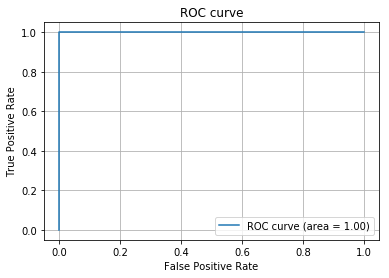

In [18]:
##roc曲線、aucの計算

# FPR, TPR(, しきい値) を算出
fpr, tpr, thresholds = metrics.roc_curve(y, y_pred)

# ついでにAUCも
auc = metrics.auc(fpr, tpr)

# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

## 【問題4】決定領域の可視化
2値分類のデータセットに対して決定領域を可視化してください。

これまで使用してきた関数に、サポートベクターを色を変えて表示する機能を加えてください。

特にSprint0で作成したシンプルデータセット1に対して以下のように分類ができるかを検証してください。

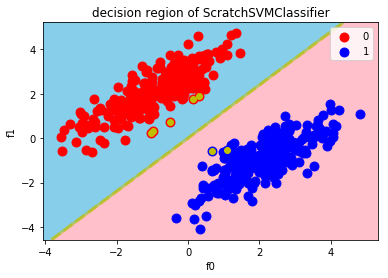

In [19]:
'''
決定領域をプロットする
'''
ssvmc.decision_region(
    X_train=X, 
    y_train=y.reshape(-1),   #set型に対応するために一次元配列にする
    title='decision region of ScratchSVMClassifier', 
    xlabel='f0', 
    ylabel='f1', 
    target_names=['0', '1']
)


## 【問題5】時間の計測
SVMの学習には時間がかかるため、効率的な実装が望まれます。事前学習期間に行なったように、時間を計測して改善していきましょう。特に $\lambda\$の更新部分は繰り返し処理が多いため、効率的なコードを目指してください。

### サンプルの行数を一時変数に格納する

In [21]:
'''
修正前の時間測定
'''
import time
t0 = time.time()

lam = np.ones((X.shape[0],1))

for i in range(X.shape[0]):
    tmp_lam = 0
    for j in range(X.shape[0]):
        tmp_lam += lam[j] * y[i] * y[j] * ssvmc._linear_kernel(X, X)[i, j]

    # サンプルごとのラムダを更新する
    lam[i] += ssvmc.lr *(1 - tmp_lam)

    # ラムダが0より小さい場合、0に更新する
    if lam[i] < 0:
        lam[i] = 0
        
t1 = time.time()

print('before_time : {}s'.format(t1-t0))


'''
修正後の時間測定
'''
t0 = time.time()

n_samples = X.shape[0]

lam = np.ones((n_samples,1))

for i in range(n_samples):
    tmp_lam = 0
    for j in range(n_samples):
        tmp_lam += lam[j] * y[i] * y[j] * ssvmc._linear_kernel(X, X)[i, j]

    # サンプルごとのラムダを更新する
    lam[i] += ssvmc.lr *(1 - tmp_lam)

    # ラムダが0より小さい場合、0に更新する
    if lam[i] < 0:
        lam[i] = 0
        
t1 = time.time()

print('after_time : {}s'.format(t1-t0))


before_time : 151.74268531799316s
after_time : 137.96314597129822s


### 結果
一時変数を利用することにより、処理時間を短くすることができた

## 【問題6】ロジスティック回帰とSVM
最終発表時に以下の内容についてディスカッションを行います。自分なりの意見を用意しておいてください。

- ロジスティック回帰とSVMは本質的に何が異なっているか  


**注意点**  
答えがある問いではありません。いろいろな視点から見て理解を深めていきましょう。

- ロジスティック回帰  
   - シグモイド関数を利用して目的関数を最小化する
   - 全ての学習データを利用して学習を行う
   - 処理時間が早い

- SVM
    - 内積を利用して目的関数を最小化する
    - サポートベクターとなるデータのみを利用して学習を行う（外れ値に強い）
    - 処理時間が遅い

## 【問題2】（アドバンス課題）多項式カーネル関数の作成
問題1では線形カーネルを使用しましたが、多項式カーネルにも切り替えられるようにしましょう。

「線形カーネルの式」
$$
    k(x_i, x_j) = x_{i}^{T} x_j
$$

「多項式カーネルの式」
$$
    k(x_i, x_j) = \gamma(x_{i}^{T} x_j + \theta_0)^{d}
$$

$\gamma, \theta_0, d$はハイパーパラメータです。  

線形カーネルは $\gamma = 1, \theta_0 = 0 , d = 1$の場合の多項式カーネルと等しいと言えます。


### irisデータセットにて動作確認

In [22]:
#irisデータセットにて、多項式カーネルを用いてSVM回帰を行う
#パラメータ設定がむずい
ssvmc2 = ScratchSVMClassifier(kernel='poly', num_iter=300, lr=1e-4, C=1, d=3, gamma=10, coef0=10)
ssvmc2.fit(X_train_std, y_train)

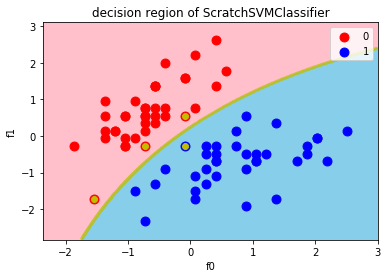

In [23]:
'''
決定領域をプロットする
'''
ssvmc2.decision_region(
    X_train=X_train_std, 
    y_train=y_train.reshape(-1),   #set型に対応するために一次元配列にする
    title='decision region of ScratchSVMClassifier', 
    xlabel='f0', 
    ylabel='f1', 
    target_names=['0', '1']
)


### シンプルデータセットにて動作確認

In [29]:
#シンプルデータセットにて、多項式カーネルを用いてSVM回帰を行う
ssvmc3 = ScratchSVMClassifier(kernel='poly', num_iter=20, lr=1e-3, C=1, d=2, gamma=10, coef0=10)
ssvmc3.fit(X, y)

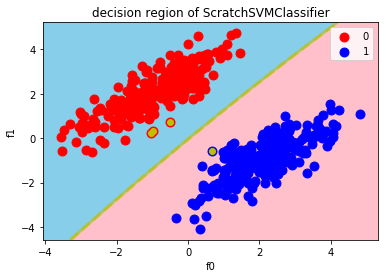

In [30]:
'''
決定領域をプロットする
'''
ssvmc3.decision_region(
    X_train=X, 
    y_train=y.reshape(-1),   #set型に対応するために一次元配列にする
    title='decision region of ScratchSVMClassifier', 
    xlabel='f0', 
    ylabel='f1', 
    target_names=['0', '1']
)


### pyファイルで確認(classify_pipeline.py)

In [26]:
#pyファイル格納ディレクトリのパス設定
import sys
sys.path.append("/Users/yusuke-saruya/diveintocode-ml/full-time/diveintocode-term1/ml-scratch/utils/")
import classify_pipeline

In [27]:
#irisデータセットにて、多項式カーネルを用いてSVM回帰を行う
ssvmc4 = classify_pipeline.ScratchSVMClassifier(kernel='poly', num_iter=300, lr=1e-4, C=1, d=3, gamma=10, coef0=10)
ssvmc4.fit(X_train_std, y_train)

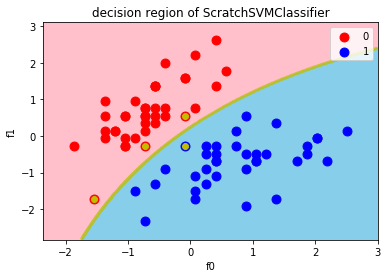

In [28]:
'''
決定領域をプロットする
'''
ssvmc4.decision_region(
    X_train=X_train_std, 
    y_train=y_train.reshape(-1),   #set型に対応するために一次元配列にする
    title='decision region of ScratchSVMClassifier', 
    xlabel='f0', 
    ylabel='f1', 
    target_names=['0', '1']
)
